In [1]:
using Revise

using CairoMakie
using FourierFlows
using GeophysicalFlows

includet("../utils/IFMAB3.jl")
includet("../swqg/TwoLayerQG.jl")
using .TwoLayerQG

In [2]:
dev = CPU()

CPU()

In [5]:
function compute_parameters(rd, l, avg_eddy_velocity, H, f)
    c₁ = 3.2
    c₂ = 0.36
    l_star = l/rd
    b2 = 1.;

    kappa_star = c₂/log(l_star/c₁)
    U = avg_eddy_velocity / l_star
    μ = 2*U*kappa_star/rd; # bottom drag
    δb = 4 * f^2 * rd^2/H
    return μ, δb, U
end

nx = 512

f0 = 3.0
H = 1.0
Cg = 1.0
g = Cg^2/H # Cg^2 = gH
avg_U = 0.2
rd = 1/3
intervortex_radius = 3/2

kmax = nx/2 - 1
nν = 4
μ, δb, U = compute_parameters(rd, intervortex_radius, avg_U, H, f0)

true_rd = δb*H/4/f0^2
kappa_star = true_rd*μ/2/U
l_star = 3.2 * exp(0.36 / kappa_star)
eddy_U = U * l_star
δρρ0 = δb/g
cfl_tune = 0.05

dt = 2π *cfl_tune / nx / eddy_U 
ν = 2π / nx / (kmax^(2*nν)) / dt

println("Deformation rad?: ", rd)
println("Deformation rad: ", true_rd)
println("Kappa star: ", kappa_star)
println("Eddy vel.: ", eddy_U)
println("CFL: ", eddy_U * dt / (2π/nx))

Deformation rad?: 0.3333333333333333
Deformation rad: 0.1111111111111111
Kappa star: 0.3519819356603909
Eddy vel.: 0.3955078125
CFL: 0.05


In [6]:
prob = TwoLayerQG.Problem(dev; stepper="IFMAB3", nx, dt, U, δρρ0, f0, Cg, ν, nν, μ, aliased_fraction=1/3, use_filter=false)
#prob2 = MultiLayerQG.Problem(2, dev; stepper="FilteredRK4", nx, dt=2.5e-3, U=[0.5, -0.5], b=[-1.0, -1.2], ν, nν, μ=5e-2, aliased_fraction=1/3)
grid = prob.grid
println("Kd2: ", f0^2/Cg^2) 
println(prob.params.F)
println(maximum(abs.(prob.eqn.L)))

Kd2: 9.0
4.5
131.36317


In [7]:
q0 = 1e-2 * device_array(dev)(randn((grid.nx, grid.ny, 2)))
q0h = rfft(q0, (1, 2))

TwoLayerQG.set_solution!(prob, q0h)

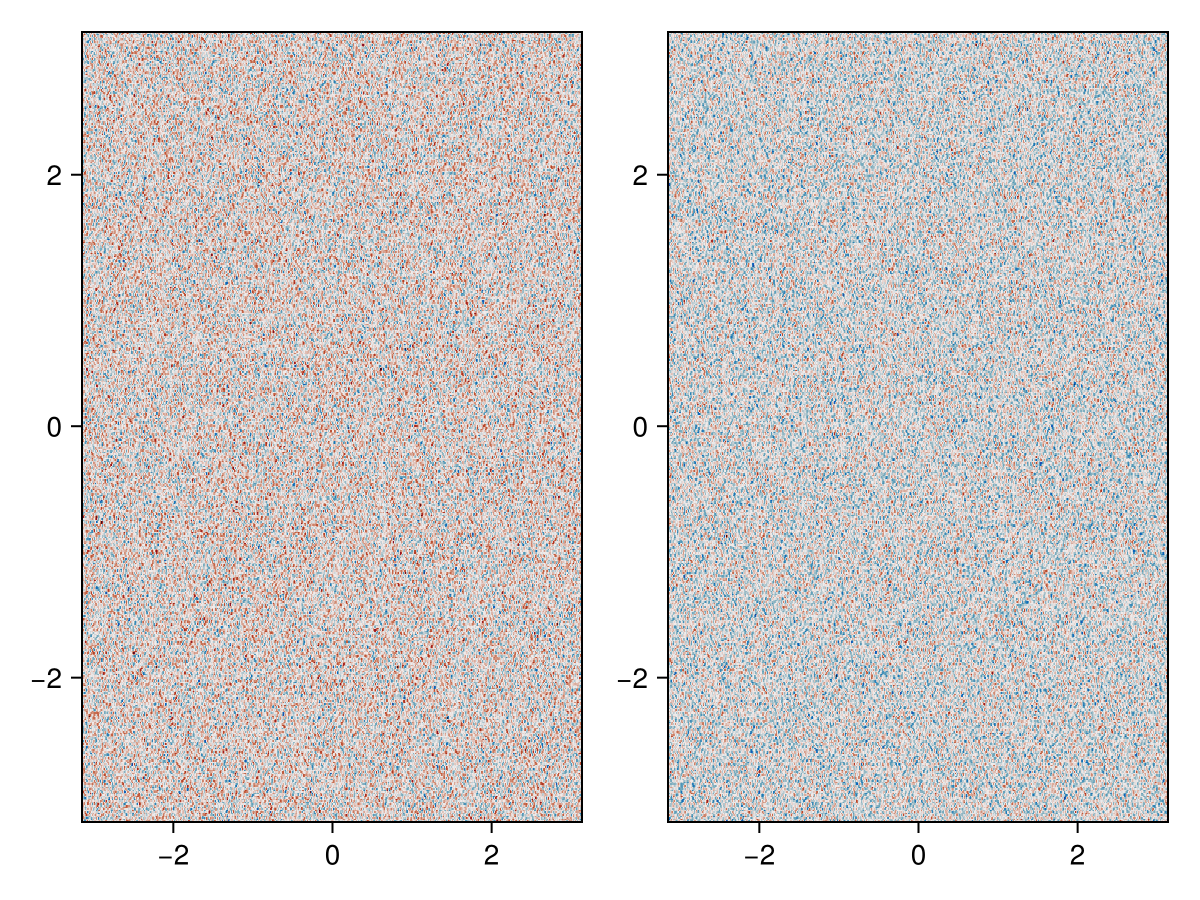

In [8]:
fig = Figure()
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])

map_q1 = Observable(Array(prob.vars.q)[:,:,1])
map_q2 = Observable(Array(prob.vars.q)[:,:,2])
heatmap!(ax1, grid.x, grid.y, map_q1, colormap=:balance)
heatmap!(ax2, grid.x, grid.y, map_q2, colormap=:balance)

fig

In [9]:
Dev = typeof(grid.device)
T = eltype(grid)

frames = 0:3000
nsubs = 50

record(fig, "test_movie.mp4", frames, framerate=18) do frame
#for frame=frames
    TwoLayerQG.stepforward!(prob, [], nsubs)
    TwoLayerQG.updatevars!(prob)

    if(frame % 25 == 0)
        max_u = max(maximum(abs.(prob.vars.u)), maximum(abs.(prob.vars.u)))
        println("t = ", prob.clock.t, ", max u: ", max_u, ", cfl: ", max_u * dt / grid.dx)
    end
    map_q1[] = Array(prob.vars.q)[:,:,1]
    map_q2[] = Array(prob.vars.q)[:,:,2]
end
println(maximum(abs2.(prob.vars.q)))
println(prob.clock.t)

t = 0.077570215, max u: 0.00033145893, cfl: 4.190295450141624e-5
t = 2.016809, max u: 0.00030672035, cfl: 3.877550991497775e-5
t = 3.956046, max u: 0.00030151938, cfl: 3.811800447401886e-5
t = 5.8955746, max u: 0.00029628514, cfl: 3.7456293594351184e-5
t = 7.8351097, max u: 0.00029318195, cfl: 3.706398834297325e-5
t = 9.774645, max u: 0.00028957464, cfl: 3.660795395434687e-5
t = 11.71418, max u: 0.00028535497, cfl: 3.607450343634891e-5
t = 13.653715, max u: 0.00028063037, cfl: 3.547722076073168e-5
t = 15.59325, max u: 0.00027535963, cfl: 3.4810896040170895e-5
t = 17.531843, max u: 0.00027057045, cfl: 3.420544900016625e-5
t = 19.470186, max u: 0.00026702526, cfl: 3.3757266235515854e-5
t = 21.40853, max u: 0.0002628436, cfl: 3.322862088195682e-5
t = 23.346872, max u: 0.0002580164, cfl: 3.261836867751326e-5
t = 25.285215, max u: 0.00025253522, cfl: 3.192543894618845e-5
t = 27.223558, max u: 0.00024888283, cfl: 3.1463705323476396e-5
t = 29.161901, max u: 0.0002553538, cfl: 3.22817643330578

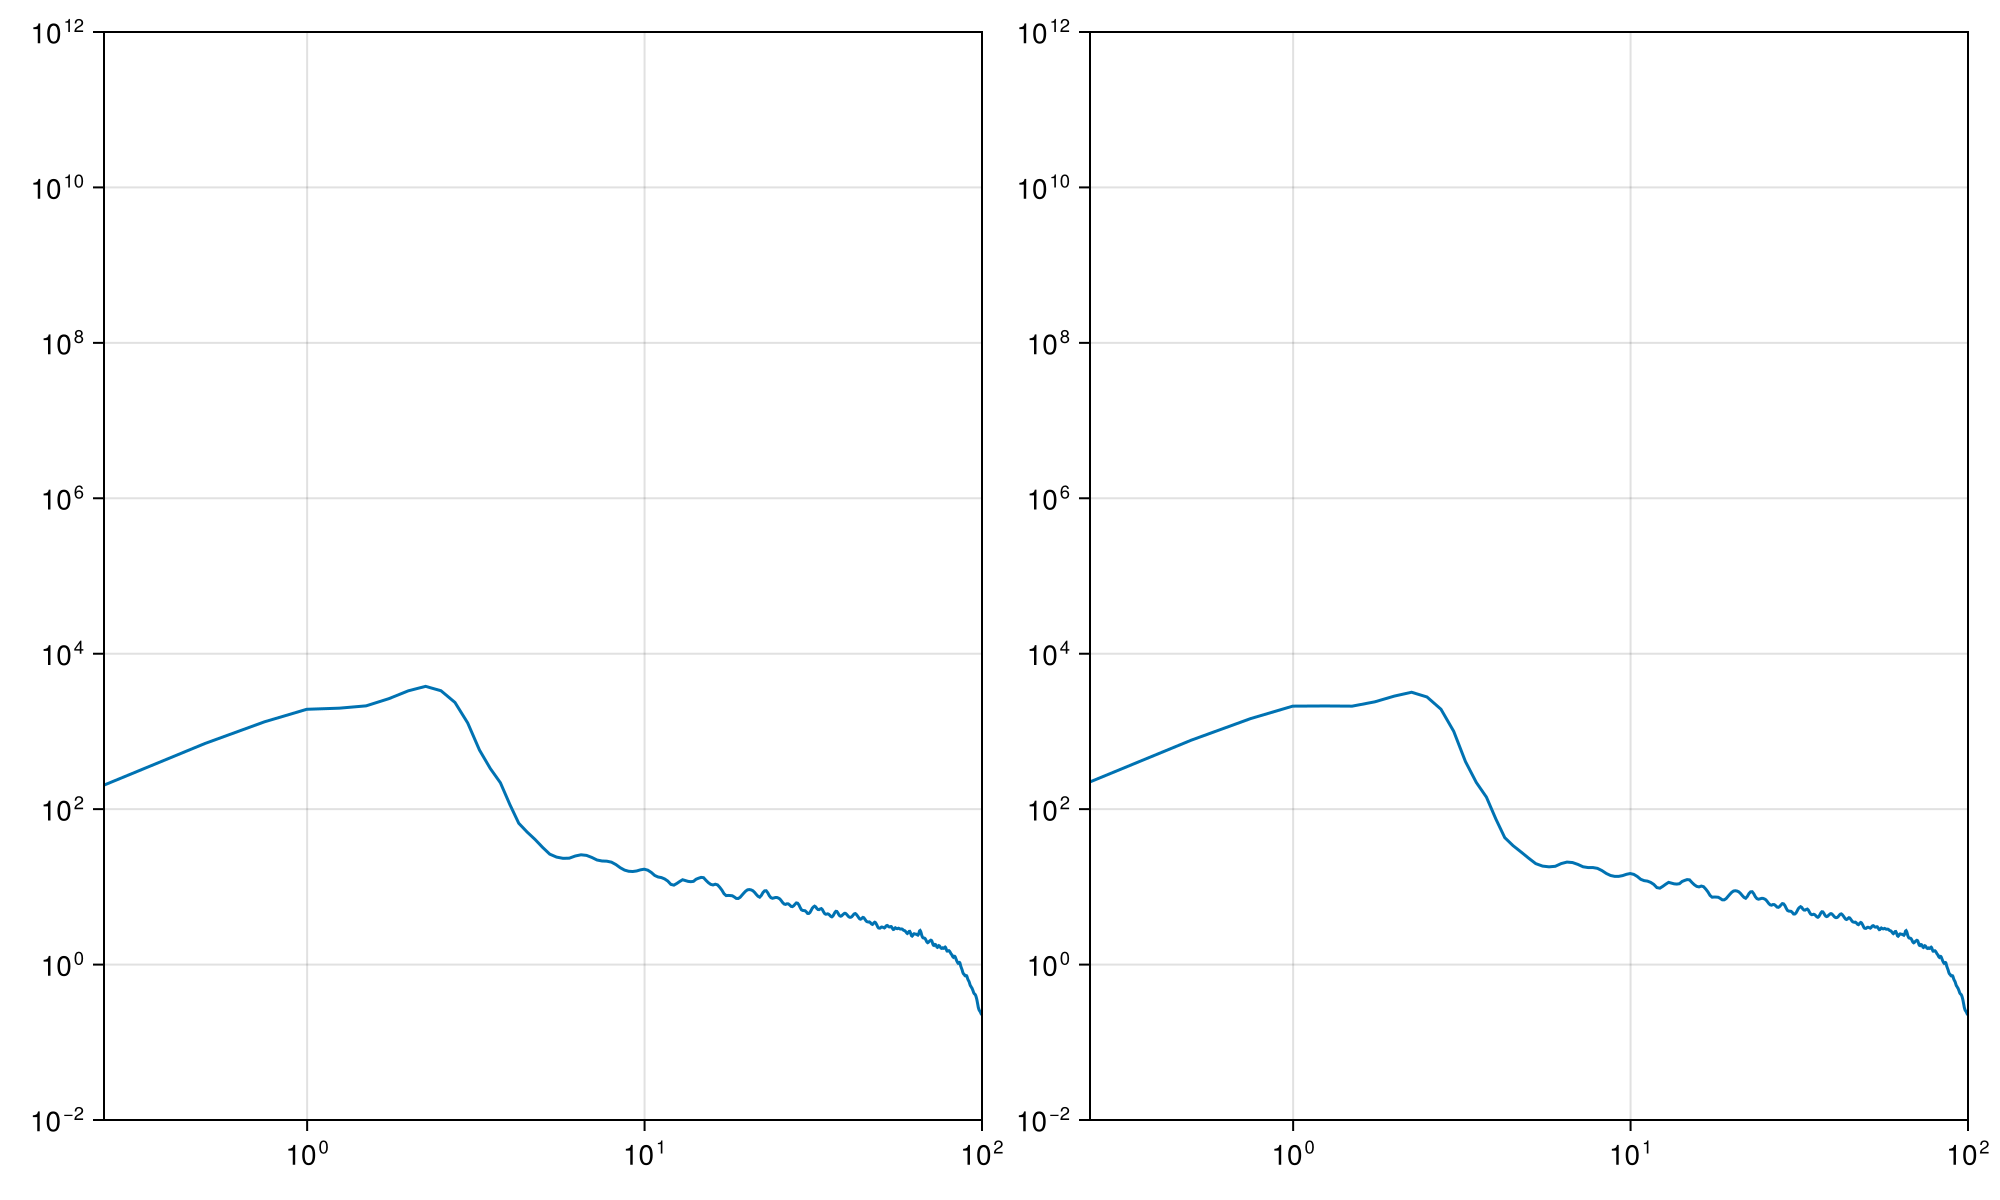

In [10]:
fig = Figure(size=(1000, 600))
ax1 = Axis(fig[1,1]; xscale=log10, yscale=log10, limits=((0.25, 100), (1e-2, 1e12)))
ax2 = Axis(fig[1,2]; xscale=log10, yscale=log10, limits=((0.25, 100), (1e-2, 1e12)))
#heatmap!(ax1, grid.x, grid.y, Array(prob.vars.q)[:,:,1], colormap=:balance)
#heatmap!(ax2, grid.x, grid.y, Array(prob.vars.q)[:,:,2], colormap=:balance)

bt_uh = sum(prob.vars.uh, dims=3)[:,:,1]
bt_vh = sum(prob.vars.vh, dims=3)[:,:,1]
bc_uh = prob.vars.uh[:,:,2] - prob.vars.uh[:,:,1]
bc_vh = prob.vars.vh[:,:,2] - prob.vars.vh[:,:,1]
ρ, bt_E_radial = FourierFlows.radialspectrum(abs2.(bt_uh) + abs2.(bt_vh), grid)
ρ, bc_E_radial = FourierFlows.radialspectrum(abs2.(bc_uh) + abs2.(bc_vh), grid)
lines!(ax1, ρ, Array(bt_E_radial)[:])
lines!(ax2, ρ, Array(bc_E_radial)[:])
fig

In [118]:
using .TwoLayerQG: calcN!
Dev = typeof(grid.device)
T = eltype(grid)
@devzeros Dev Complex{T} (grid.nkr, grid.nl, 2) N1 N2

TwoLayerQG.calcN!(N1, prob.sol, 0, prob.clock, prob.vars, prob.params, grid)
MultiLayerQG.calcN!(N2, prob.sol, 0, prob.clock, prob2.vars, prob2.params, grid)

In [161]:
FourierFlows.parsevalsum2(prob.vars.uh, grid)

LoadError: BoundsError: attempt to access 257×512×2 CuArray{ComplexF64, 3, CUDA.DeviceMemory} at index [1, 1:512]

In [120]:
using CUDA
i = 20
j = 123
println(CUDA.@allowscalar prob2.params.S⁻¹[i,j])
inv_detM = @. grid.invKrsq / (grid.Krsq + 2*prob.params.F)
CUDA.@allowscalar print("[", -inv_detM[i,j]*(grid.Krsq[i,j] + prob.params.F), " ", -inv_detM[i,j]*(prob.params.F), "; ")
CUDA.@allowscalar println(-inv_detM[i,j]*(prob.params.F), " ", -inv_detM[i,j]*(grid.Krsq[i,j] + prob.params.F))

#    @. ψ1h = -(grid.Krsq * q1h + params.F * (q1h + q2h))
#    @. ψ2h = -(grid.Krsq * q2h + params.F * (q1h + q2h))
#    @. ψh /= grid.Krsq + 2*params.F
#    @. ψh *= grid.invKrsq

[-0.0024584866112148064 -6.0405076442624246e-5; -6.0405076442624246e-5 -0.0024584866112148064]


[-0.0024909729374247742 -2.791875023265625e-5; -2.791875023265625e-5 -0.0024909729374247742


In [121]:
@devzeros Dev Complex{T} (grid.nkr, grid.nl, 2) N1 N2

prob2.sol .= prob.sol
MultiLayerQG.updatevars!(prob2)

TwoLayerQG.dealias!(prob.sol, grid)
MultiLayerQG.dealias!(prob2.sol, prob2.grid)

@. prob.vars.qh = prob.sol
@. prob2.vars.qh = prob.sol

TwoLayerQG.streamfunctionfrompv!(prob.vars.ψh, prob.vars.qh, prob.grid, prob.params)
MultiLayerQG.streamfunctionfrompv!(prob2.vars.ψh, prob2.vars.qh, prob2.params, prob2.grid)

@. prob.vars.uh = -im * grid.l  * prob.vars.ψh
@. prob2.vars.uh = -im * grid.l  * prob2.vars.ψh
@. prob.vars.vh =  im * grid.kr * prob.vars.ψh
@. prob2.vars.vh =  im * grid.kr * prob2.vars.ψh

TwoLayerQG.invtransform!(prob.vars.u, prob.vars.uh, grid)
MultiLayerQG.invtransform!(prob2.vars.u, prob2.vars.uh, prob2.params)

@views @. prob.vars.u[:,:,1] += prob.params.U      # add the imposed zonal flow U
@views @. prob.vars.u[:,:,2] -= prob.params.U      # add the imposed zonal flow U
@views @. prob2.vars.u += prob2.params.U      # add the imposed zonal flow U

uQx, uQxh = prob.vars.q, prob.vars.uh              # use vars.q and vars.uh as scratch variables
uQx2, uQxh2 = prob2.vars.q, prob2.vars.uh              # use vars.q and vars.uh as scratch variables

@. uQx = prob.vars.u * 0              # (U+u)*∂Q/∂x
@. uQx2 = prob2.vars.u * prob2.params.Qx              # (U+u)*∂Q/∂x

TwoLayerQG.fwdtransform!(uQxh, uQx, grid)
MultiLayerQG.fwdtransform!(uQxh2, uQx2, prob2.params)

@. N1 = - uQxh                            # -\hat{(U+u)*∂Q/∂x}
@. N2 = - uQxh2                            # -\hat{(U+u)*∂Q/∂x}

CUDA.@allowscalar println(maximum(abs.(N1 - N2)))

TwoLayerQG.invtransform!(prob.vars.v, prob.vars.vh, grid)
MultiLayerQG.invtransform!(prob2.vars.v, prob2.vars.vh, prob2.params)

vQy, vQyh = prob.vars.q, prob.vars.vh              # use vars.q and vars.vh as scratch variables
vQy2, vQyh2 = prob2.vars.q, prob2.vars.vh              # use vars.q and vars.vh as scratch variables

@views @. vQy[:,:,1] =  prob.vars.v[:,:,1] * 2              # v*∂Q/∂y
@views @. vQy[:,:,2] = -prob.vars.v[:,:,2] * 2              # v*∂Q/∂y
@. vQy2 = prob2.vars.v * prob2.params.Qy              # v*∂Q/∂y

CUDA.@allowscalar println(maximum(abs.(vQy - vQy2)))

TwoLayerQG.fwdtransform!(vQyh, vQy, grid)
MultiLayerQG.fwdtransform!(vQyh2, vQy2, prob2.params)

@. N1 -= vQyh                             # -\hat{v*∂Q/∂y}
@. N2 -= vQyh2                             # -\hat{v*∂Q/∂y}

CUDA.@allowscalar println(maximum(abs.(vQyh - vQyh2)))
CUDA.@allowscalar println(maximum(abs.(N1 - N2)))

TwoLayerQG.invtransform!(prob.vars.q, prob.vars.qh, grid)
MultiLayerQG.invtransform!(prob2.vars.q, prob2.vars.qh, prob2.params)

uq , vq  = prob.vars.u , prob.vars.v               # use vars.u and vars.v as scratch variables
uqh, vqh = prob.vars.uh, prob.vars.vh              # use vars.uh and vars.vh as scratch variables
uq2 , vq2  = prob2.vars.u , prob2.vars.v               # use vars.u and vars.v as scratch variables
uqh2, vqh2 = prob2.vars.uh, prob2.vars.vh              # use vars.uh and vars.vh as scratch variables

@. uq *= prob.vars.q                          # (U+u)*q
@. vq *= prob.vars.q                          # v*q
@. uq2 *= prob2.vars.q                          # (U+u)*q
@. vq2 *= prob2.vars.q                          # v*q
TwoLayerQG.fwdtransform!(uqh, uq, grid)
TwoLayerQG.fwdtransform!(vqh, vq, grid)
MultiLayerQG.fwdtransform!(uqh2, uq2, prob2.params)
MultiLayerQG.fwdtransform!(vqh2, vq2, prob2.params)
@. N1 -= im * grid.kr * uqh + im * grid.l * vqh    # -\hat{∂[(U+u)q]/∂x} - \hat{∂[vq]/∂y}
@. N2 -= im * grid.kr * uqh2 + im * grid.l * vqh2    # -\hat{∂[(U+u)q]/∂x} - \hat{∂[vq]/∂y}

CUDA.@allowscalar println(maximum(abs.(N1 - N2)))

# Apply bottom drag
@views @. N1[:,:,2] += prob.params.μ * grid.Krsq * prob.vars.ψh[:,:,2]
@views @. N2[:,:,2] += prob2.params.μ * grid.Krsq * prob2.vars.ψh[:,:,2]

CUDA.@allowscalar println(maximum(abs.(N1 - N2)))

LoadError: ArgumentError: CuFFT plan applied to wrong-size input

In [245]:
2 * prob.params.F * prob.params.U

2.0

In [18]:
Val(3)

Val{3}()

In [203]:
U = 0.5
nn = grid.nx
U_3D = zeros(1, nn, 2)
U_3D[:,:,1] .= U
U_3D[:,:,2] .= -U
l = Array(grid.l)
ifft(fft(-l.*l.*U_3D, (1,2)), (1,2))

1×128×2 Array{ComplexF64, 3}:
[:, :, 1] =
 -2.27374e-13+0.0im  -0.5-1.77636e-15im  …  -0.5+1.77636e-15im

[:, :, 2] =
 2.27374e-13+0.0im  0.5+1.77636e-15im  …  0.5-1.77636e-15im

In [1]:
using JLD2
using CairoMakie
using FourierFlows
using AbstractFFTs
include("../utils/IFMAB3.jl")
include("../swqg/TwoLayerQG.jl")
using .TwoLayerQG

In [2]:
data_file = jldopen("/scratch/nad9961/twolayer_rays/59310910/packets.000000.jld2")
length()

LoadError: MethodError: no method matching length()

[0mClosest candidates are:
[0m  length([91m::Scene[39m)
[0m[90m   @[39m [35mMakie[39m [90m/ext3/pkgs/packages/Makie/8h0bl/src/[39m[90m[4mscenes.jl:369[24m[39m
[0m  length([91m::LibGit2.GitBlob[39m)
[0m[90m   @[39m [36mLibGit2[39m [90m/ext3/julia-1.10.5/share/julia/stdlib/v1.10/LibGit2/src/[39m[90m[4mblob.jl:3[24m[39m
[0m  length([91m::LibGit2.GitStatus[39m)
[0m[90m   @[39m [36mLibGit2[39m [90m/ext3/julia-1.10.5/share/julia/stdlib/v1.10/LibGit2/src/[39m[90m[4mstatus.jl:21[24m[39m
[0m  ...


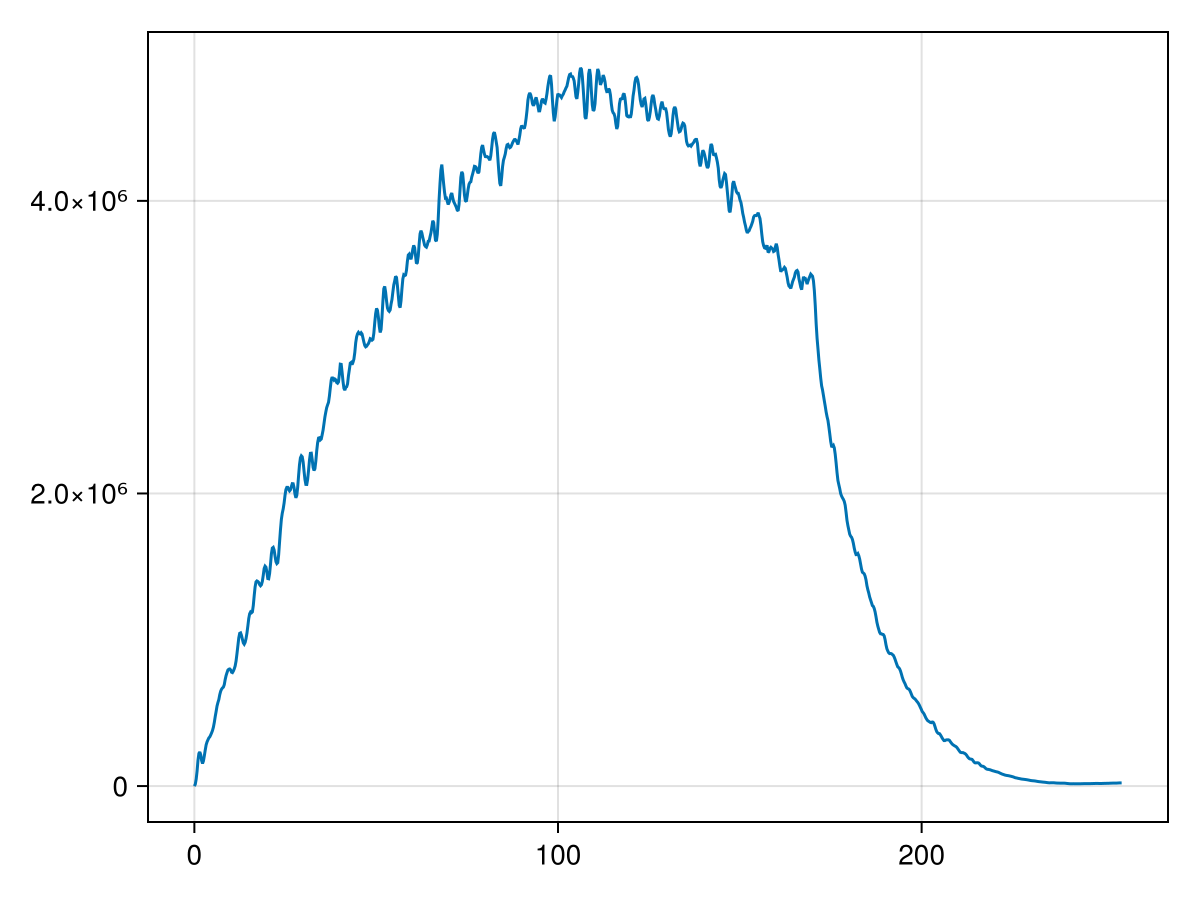

In [74]:
function compute_cross_term(solh, grid, params)
    sol = irfft(solh, grid.nx)
    
    ψh = zeros(Complex{Float64}, grid.nkr, grid.nl, 2)
    TwoLayerQG.streamfunctionfrompv!(ψh, solh, grid, params)
    
    ψhc = ψh[:,:,1] - ψh[:,:,2]
    ζhc = -grid.Krsq .* ψhc
    ζhcx = 1im * grid.kr .* ζhc
    ζhcy = 1im * grid.l .* ζhc
    
    ζcx = irfft(ζhcx, grid.nx)
    ζcy = irfft(ζhcy, grid.nx)
    ψc  = irfft(ψhc,  grid.nx)
    
    term1 = ψc .* ζcy
    term2 = ψc .* ζcx
    
    term1h = rfft(term1)
    term2h = rfft(term2)
    
    Fh = 1im * grid.kr .* term1h - 1im * grid.l .* term2h
    return Fh
end

Fh = zeros(Complex{Float64}, grid.nkr, grid.nl)
grid = TwoDGrid(; Lx=2π, nx=512)
F = data_file["params/F"]
params = (; F)
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10)
for idx=200:554
    solh = data_file["snapshots/sol/" * keys(data_file["snapshots/sol/"])[idx]]
    Fh1 = compute_cross_term(solh, grid, params)
    Fh += Fh1
end

ρ, Fhr = FourierFlows.radialspectrum(abs.(Fh), grid)
lines(ρ, Fhr[:])

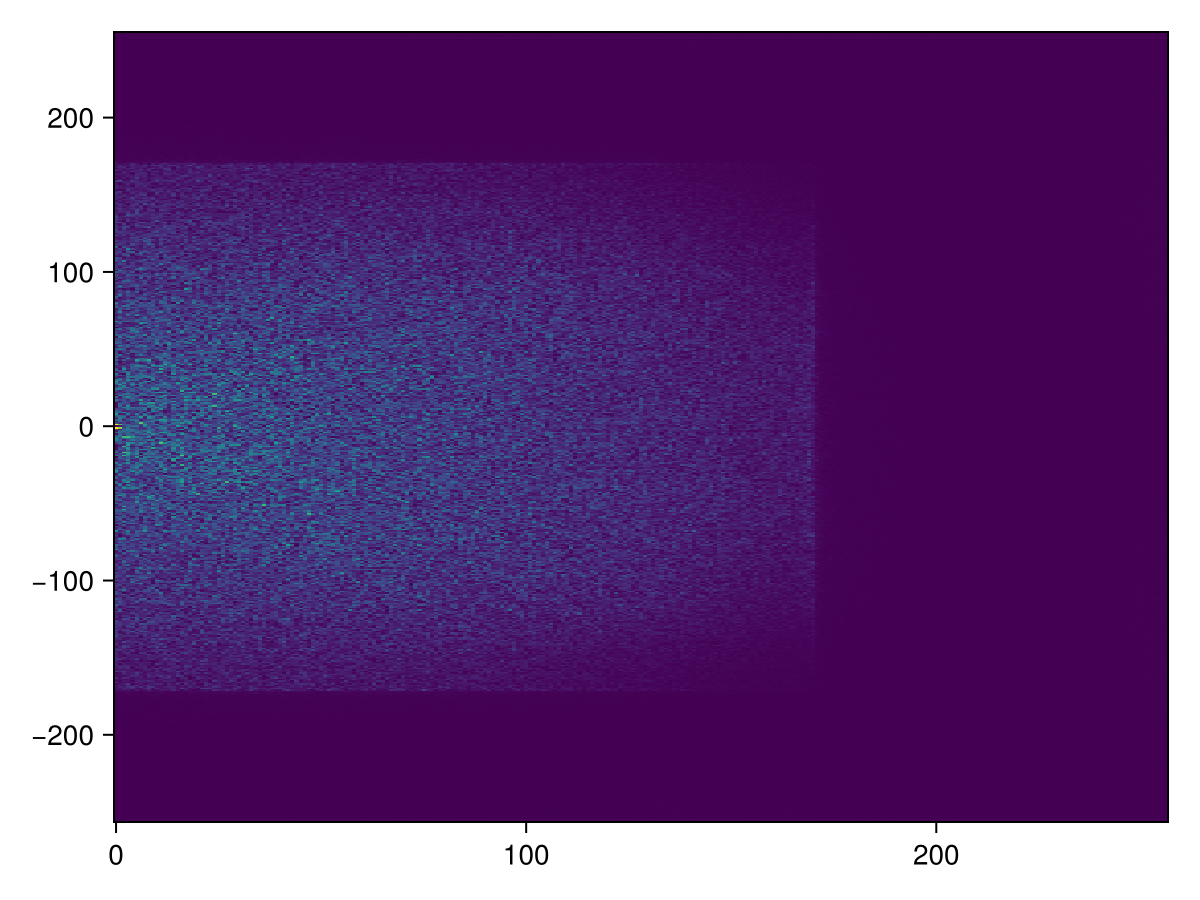

In [73]:
heatmap(grid.kr[:], fftshift(grid.l)[:], fftshift((abs.(Fh)), 2))

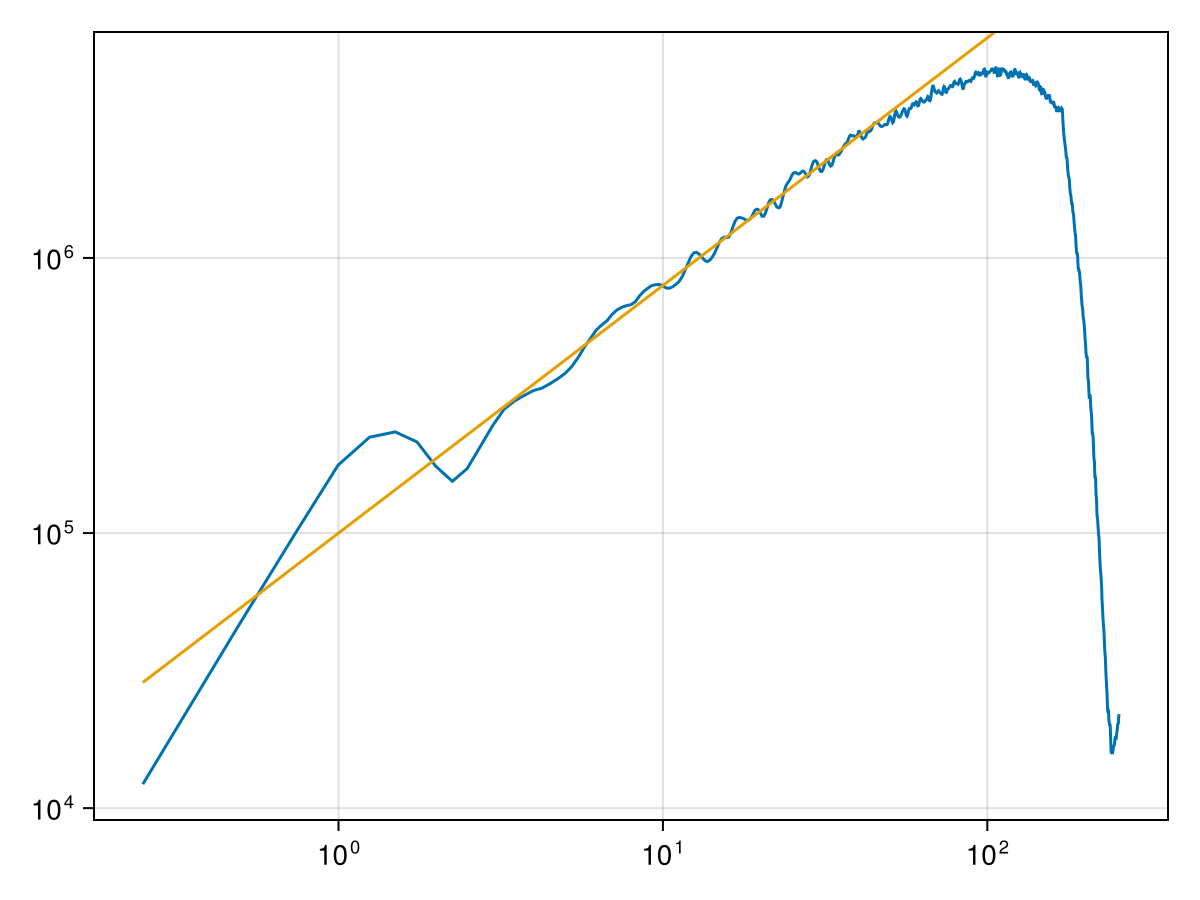

In [95]:
fig = Figure()
ax = Axis(fig[1,1];xscale=log10, yscale=log10)
lines!(ax, ρ, replace(Fhr[:], 0.0=>NaN))
lines!(ax, ρ, 1e5*ρ.^0.90)

fig